# Face Generator

## Project

Imagine that you worked for a movie producer and your job was to design characters for a next movie. Based on the script, you can probably imagine personality and style of each person. The only thing that left to do is to draw them. This step is probably the hardest and it takes a lot of sketches to finally come up with a good one.

But what if the computer drew new faces for you and you only needed to select the perfect one. You probably agree with me that it would be much easier than sketching. Well... I am going to make your and other character designers' lifes easier by building such a generator!

## Outline

I start with training a discriminator whose job is to distinguish between real images, coming from a training set, and fake ones coming out of the generator. When it learns how to recognize a fake image, I start to train the generator. It slowly learns to produce images of higher quality. It knows that it moves in a right direction, when more of its images are classified as real by the discriminator. This is basically how you train a GAN. At the end, you only keep the generator.

I follow this framework and train the discriminator using a dataset of face images. This way, it learns to recognize genuine profile pictures. From this point, generator will try its best to produce an image that would pass as a real one. So it has no choice but to learn how to create a realistic face image.

## Imports

In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests

%matplotlib inline

import torch
from torchvision import datasets
from torchvision import transforms

## Load the data

I will use the CelebA dataset that contains around 200,000 annotated images. You don't need to use the annotations. The discriminator will classify images as real or fake by just looking at them. You also want the network to focus only on what is important, so the faces should be cropped out.

I'm going to load a subset of 90,000 pictures that were initially transformed. They contain faces only and are of the same size (64, 64, 3).

In [2]:
def get_dataloader(batch_size, image_size, data_dir = 'data/'):
    '''Supplies batches of data for training.
    
    Args:
        batch_size(int): number of images in a batch
        img_size(int): image width or height
        data_dir(string): directory with training images
    
    Returns: DataLoader object
    '''
    
    # Resize each image and convert batchers to tesnsors
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    # Read transformed image data
    dataset = datasets.ImageFolder(root = data_dir, 
                                   transform = transform)
    
    data_loader = torch.utils.data.DataLoader(dataset = dataset,
                                              batch_size = batch_size,
                                              shuffle = True)
    
    return data_loader


In [3]:
# Data loader parameters
batch_size = 128
img_size = 32

# Run the code
celeba_train_loader = get_dataloader(batch_size, img_size)

Let's see how the loaded images look like.

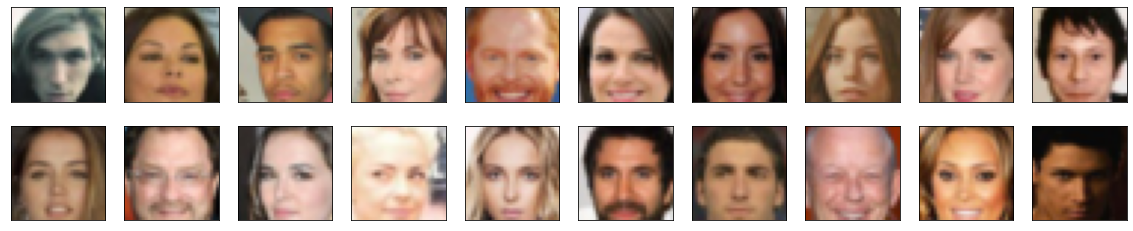

In [4]:
def imshow(img):
    '''Takes in image tensor and displays it'''
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

# Get a batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# Plot 20 images images from the batch
fig = plt.figure(figsize = (20, 4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size / 2, idx + 1, xticks = [], yticks = [])
    imshow(images[idx])

Everything seems right. The images are squares and contain just the faces.

### Rescaling

Right now, the images are in a range of 0 to 1 butut they need to be in [-1, 1]. You may wonder why. Discriminator will have to work both with training images and generated ones. Since the generator uses `tanh` activation and outputs images in a range of [-1, 1], it will be easier to rescale the training images in this way.

I'm going to write a rescaling function that I will use later.

In [5]:
def scale(x, feature_range = (-1, 1)):
    '''Takes in an image x in a range [0, 1] and returns that image rescaled to given range'''
    # Scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    
    return x

In [6]:
# Test it on a single image
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8588)
Max:  tensor(0.9765)


I also made a little test and applied it to a sample image. Minimum value is greater than -1 and maximum is below 1. It works correctly.